In [94]:
import numpy as np
import pdb
from pandas_plink import read_plink
from limix_lmm import LMM
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
import seaborn as sns

## Linear regression

#### Generate data

In [41]:
# Define the sample size and number of covariates
N = 5000
K = 3

# Generate the covariate matrix and the true effect sizes
X = np.hstack([np.ones((N, 1)), np.random.randn(N, K)])

beta_true = np.linspace(0.1, 0.4, K+1)

# Generate the phenotype
y = X.dot(beta_true) + np.random.randn(N)

Compute MLE for beta and sigma^2 and the log marginal likelihood of the model.

Parameters:
- y: observed data
- X: design matrix with covariates (without intercept)

Returns:
- beta_hat: MLE of beta
- sigma2_hat: MLE of sigma squared
- log_marginal_likelihood: log marginal likelihood of the model

In [42]:
def compute_MLE_and_LML(y, X):
    """
    Compute MLE for beta and sigma^2, standard errors for beta, 
    and the log marginal likelihood of the model.
    
    Parameters:
    - y: observed data
    - X: design matrix with covariates
    
    Returns:
    - beta_hat: MLE of beta
    - beta_se: Standard errors for beta
    - sigma2_hat: MLE of sigma squared
    - log_marginal_likelihood: log marginal likelihood of the model
    """
    
    # Compute MLE for beta using the closed-form solution
    beta_hat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    
    # Compute residuals
    residuals = y - X.dot(beta_hat)
    
    # Compute MLE for sigma squared (variance of the residuals)
    sigma2_hat = residuals.T.dot(residuals) / len(y)
    
    # Compute standard errors for beta_hat
    beta_se = np.sqrt(sigma2_hat * np.diag(np.linalg.inv(X.T.dot(X))))
    
    # Compute the log marginal likelihood of the model
    log_marginal_likelihood = np.sum(st.norm.logpdf(y, loc=X.dot(beta_hat), scale=np.sqrt(sigma2_hat)))
    
    return beta_hat, beta_se, sigma2_hat, log_marginal_likelihood

In [43]:
# Add a bias term (intercept) to X
beta_hat, beta_se, sigma2_hat, lml = compute_MLE_and_LML(y, X)

In [44]:
print(f"MLE of effect size (beta):", beta_hat)
print(f"Standard errors of effect size (beta_se):", beta_se)
print(f"MLE of residual variance (sigma2): {sigma2_hat:.4f}")
print(f"LML: {lml:.4f}")

MLE of effect size (beta): [0.11634087 0.21388185 0.29901934 0.39236173]
Standard errors of effect size (beta_se): [0.01423916 0.01439681 0.01416831 0.01405056]
MLE of residual variance (sigma2): 1.0137
LML: -7128.6637


* Plot Estimated vs True Beta with Standrd errors
* What happens if you increase sample size? $500\longrightarrow{1000}\longrightarrow{5000}$

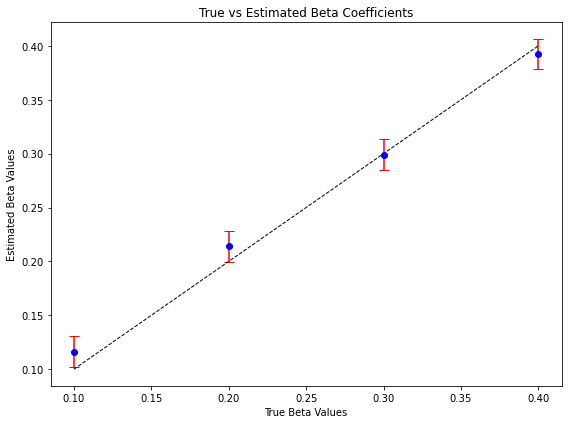

In [46]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.errorbar(beta_true, beta_hat, yerr=beta_se, fmt='o', color='blue', ecolor='red', capsize=5)
plt.plot([min(beta_true), max(beta_true)], [min(beta_true), max(beta_true)], 'k--', lw=1)  # Diagonal line for reference

plt.xlabel('True Beta Values')
plt.ylabel('Estimated Beta Values')
plt.title('True vs Estimated Beta Coefficients')
plt.tight_layout()

plt.show()

## Linear models for genetics

**Objectives:**
- **Given \(N=500\) samples:**
    1. Generate age, sex, and one genotype.
    2. Generate a phenotype as a linear function of age and sex (null model).
- **Build a lrt_test function:**
    1. Function should take as input: phenotype, covariates (age and sex), and genotype vector.
    2. Returns should include: effect size (beta), standard error (se), and p-value.

#### Generate data

In [52]:
# Set seed for reproducibility
np.random.seed(42)

# Number of samples
N = 500

# Generate random age between 20 and 80
age = np.random.randint(20, 80, (N, 1))

# Generate random sex (0 = male, 1 = female)
sex = np.random.randint(0, 2, (N, 1))

# Generate random genotype (0, 1, or 2) using binomial with 2 trials and specified allele frequency
maf = 0.3 # minor allele frequency
genotype = np.random.binomial(2, p, (N, 1))

# Generate phenotype
variance_age = 0.10
variance_sex = 0.10
variance_genotype = 0.
variance_noise = 1 - variance_age - variance_sex - variance_genotype
phenotype = np.sqrt(variance_age) * StandardScaler().fit_transform(age)
phenotype+= np.sqrt(variance_sex) * StandardScaler().fit_transform(sex)
phenotype+= np.sqrt(variance_genotype) * StandardScaler().fit_transform(genotype)
phenotype+= np.sqrt(variance_noise) * np.random.normal(0, 1, (N, 1))

In [54]:
# final data
F = np.column_stack((np.ones(N), age, sex))
g = genotype
y = phenotype

In [61]:
def lrt_test(y, F, g):
    """
    Conducts a likelihood ratio test for a given genotype and set of covariates.
    
    Parameters:
    - y: observed data (phenotype)
    - F: design matrix for null model (covariates without genotype)
    - g: genotype data
    
    Returns:
    - beta_geno: Effect size of genotype under the alternative model
    - beta_se_geno: Standard error of the effect size of genotype under the alternative model
    - p_value: p-value from the likelihood ratio test
    """